In this notebook, we will tie in many of the pieces covered in this tutorial.

First, we will take a materials dataset, in the form of cartesian coordinates, and translate it into SOAP descriptors using `librascal`, as was covered briefly in [**X_ImportingData.ipynb**](X_ImportingData.ipynb).

Next, we'll reduce the feature space of these SOAP vectors using PCov-CUR, which is covered in [**5_CUR.ipynb**](5_CUR.ipynb). 

From here, we'll select an _active_ set of samples using PCov-CUR and use them to build a set of sparse kernels, as was introduced [**4_SparseKernelMethods.ipynb**](4_SparseKernelMethodsipynb), and use this sparse kernel to build a `SparseKPCovR` map.

Finally, we will port this `SparseKPCovR` into a `chemiscope` visualization (covered in [**1_LinearMethods.ipynb**](1_LinearMethods.ipynb)), which can be loaded on [chemiscope.org](chemiscope.org).

With each of the sections, we'll provide a "fast-forward" cell, where you can skip the section by un-commenting and executing the cell. For example, if you have pre-computed your SOAP vectors and would like to simply import them, skip section 1 and execute the cell under `1.1 Skip Computing SOAPS`.

To run all cells of this notebook, you will need to have the following packages installed:
- numpy (https://numpy.org/)
- scikit-learn (https://www.scikit-learn.org)
- scipy (https://www.scipy.org)
- matplotlib (https://www.https://matplotlib.org/)
- ase (https://wiki.fysik.dtu.dk/ase/)
- librascal (https://github.com/cosmo-epfl/librascal)
- scikit-cosmo (https://github.com/cosmo-epfl/scikit-cosmo)
- chemiscope ((https://github.com/cosmo-epfl/chemiscope)

In [1]:
#!/usr/bin/env python3
import sys
import numpy as np
from sklearn.linear_model import RidgeCV


def calc_rmse(y1, y2, y_scaler, rounding=4):
    """quick function to compute the root-mean-squared-error in real units

    Parameters
    ==========
    y1, y2: ndarray (n_samples x n_properties)
            predicted and true property values in reduced units.
            order is not important.
    y_scaler: trained scaler which can return y1 and y2 to real units by calling y_scaler.inverse_transform
    rounding: int
              number of decimals to round to, defaults to 4
    """

    rmse = round(
        np.mean(
            (y_scaler.inverse_transform(y1) - y_scaler.inverse_transform(y2)) ** 2.0
        )
        ** 0.5,
        4,
    )
    return rmse

# Load data and Compute SOAP Vectors

In [2]:
# Atomistic structure manipulation
from ase import io

# Librascal
from rascal.representations import SphericalInvariants as SOAP

**Because we are using environment-centred properties in this demonstration, we pull the properties from the frame.arrays object.**

In [3]:
N = 20
input_file = "../datasets/CSD-1000R.xyz"
properties = ["CS_local", "CS_total"]
target = "atom"

# Read the first N frames of the input file
frames = np.asarray(io.read(input_file, index=":{}".format(N)), dtype=object)

# Wrap the frames
for frame in frames:
    frame.wrap()

Y_raw = np.vstack(
    [np.concatenate([frame.arrays[prop] for frame in frames]) for prop in properties]
).T
print("Within the {} frames we have {} environments.".format(N, len(Y_raw)))

Within the 20 frames we have 2538 environments.


In [4]:
# Compute SOAPs (from librascal tutorial in X_ImportingData.ipynb)
hypers = dict(
    soap_type="PowerSpectrum",
    interaction_cutoff=3.5,
    max_radial=6,
    max_angular=6,
    gaussian_sigma_type="Constant",
    gaussian_sigma_constant=0.4,
    cutoff_smooth_width=0.5,
)
soap = SOAP(**hypers)

soap_rep = soap.transform(frames)
X_raw = soap_rep.get_features(soap)

num_features = X_raw.shape[1]
print(f"There are {num_features} features")

There are 2520 features


In [5]:
# np.savez('soap_file.npz', X=X_raw, Y=Y_raw, property_names=properties, target=target)
# np.savez('soap_hypers.npz', **hypers)

## Skip Computing SOAPs

In [6]:
# # Atomistic structure manipulation
# from ase import io

# # Read/load SOAP vectors from numpy file
# soap_file = 'soap_file.npz'
# data = np.load(soap_file)
# X_raw = data['X'] # soap vectors (n_samples x n_features)
# Y_raw = data['Y'] # property vectors (n_samples x n_properties)
# target = data['target']
# properties = data['property_names'] # names of your properties

# hyper_file = 'soap_hypers.npz'
# hypers = np.load(hyper_file)

# num_features = X_raw.shape[1]

# # If you end up wanting a chemiscope, you'll need to load your frames as well
# ase_file = "../datasets/CSD-1000R.xyz"
# frames = np.asarray(io.read(ase_file, ':'), dtype=object)

# Split into training, validation, and testing subset and standardize

## Do a random, test-train split

In [7]:
from sklearn.model_selection import train_test_split

f_train = 0.7
f_test = 0.3

i_train, i_test = train_test_split(np.arange(X_raw.shape[0]), test_size=f_test)

In [8]:
# np.savez('split_file.npz', i_train=i_train, i_test=i_test)

### Skip test-train split

In [9]:
# # Import testing and training indices from numpy file

# index_file = 'split_file.npz'

# data = np.load(index_file)
# i_train = data['i_train']
# i_test = data['i_test']

## Scale and Center data

In [10]:
from skcosmo.preprocessing import StandardFlexibleScaler

X_raw_train, X_raw_test = X_raw[i_train], X_raw[i_test]
Y_train, Y_test = Y_raw[i_train], Y_raw[i_test]

x_scaler = StandardFlexibleScaler(column_wise=False)
y_scaler = StandardFlexibleScaler(column_wise=True)

Y_train = y_scaler.fit_transform(Y_train)
Y_test = y_scaler.transform(Y_test)
Y = y_scaler.transform(Y_raw)

X_raw_train = x_scaler.fit_transform(X_raw_train)
X_raw_test = x_scaler.transform(X_raw_test)
X = x_scaler.transform(X_raw)

# Sub-select the SOAP Features

The best results from PCov-CUR comes from using regression properties, so we can do a quick cross-validated ridge regression.

In [11]:
r = RidgeCV(cv=4, fit_intercept=False, alphas=np.logspace(-8, 2, 10))
r.fit(X_raw_train, Y_train)

Yp_train = r.predict(X_raw_train)
Yp_test = r.predict(X_raw_test)
rmse = calc_rmse(Y_test, Yp_test, y_scaler)

print(f"This regression has an RMSE of {rmse}ppm on the testing set.")

This regression has an RMSE of 12.6616ppm on the testing set.


## Reducing the number of features
Because (for now) using CUR is more costly than FPS, let's reduce the number of features first with FPS.

We have set `mixing` to 0.5 for all the following methods.

### Use FPS on the features to remove redundancies

In [12]:
from skcosmo.selection import FeatureFPS

num_FPS = int(num_features / 4)
fps_mixing = 0.5

print(f"Selecting {num_FPS} features")
ffps = FeatureFPS(X=X_raw_train, Y=Yp_train, mixing=fps_mixing, progress_bar=True)
fps_idx = np.array(ffps.select(num_FPS))

X_fps_train = X_raw_train[:, fps_idx]
X_fps_test = X_raw_test[:, fps_idx]

Selecting 630 features


In [13]:
# # Skip using FPS

# fps_idx = np.arange(X_raw_train.shape[1])

### Demonstrate the superiority of the FPS indices to a set of random selections

In [14]:
# r = RidgeCV(cv=4, fit_intercept=False, alphas=np.logspace(-8, 2, 10))
# r.fit(X_fps_train, Y_train)

# Yp_test = r.predict(X_fps_test)
# rmse = calc_rmse(Yp_test, Y_test, y_scaler)

# print(
#     f"The regression now has an RMSE of {rmse}ppm on the testing set, using only {num_FPS} / {num_features} features."
# )

# n_random = 10
# rmses = []

# for i in range(n_random):
#     random_feat = np.random.choice(num_features, size=num_FPS)
#     r.fit(X_raw_train[:, random_feat], Y_train)
#     Yp_random_test = r.predict(X_raw_test[:, random_feat])

#     rmses.append(calc_rmse(Yp_random_test, Y_test, y_scaler))

# rmse = round(np.mean(rmses), 4)
# rmse_dev = round(np.std(rmses), 2)

# print(f"By comparison, a regression on {num_FPS} random features gives an RMSE of {rmse}±{rmse_dev} ppm.")

### Use CUR selection to find the most information-rich feature vectors

Note: This process can take some time, especially with larger matrices.

In [15]:
from skcosmo.selection import FeatureCUR

num_CUR = int(num_features / 10)
cur_mixing = 0.5

print(f"Selecting {num_CUR} features")
fcur = FeatureCUR(X=X_fps_train, Y=Yp_train, mixing=cur_mixing, progress_bar=True)
cur_idx = fps_idx[fcur.select(num_CUR)]

Selecting 252 features


In [16]:
X_train = X_raw_train[:, cur_idx]
X_test = X_raw_test[:, cur_idx]

In [17]:
# np.savez('cur_file.npz', idx=cur_idx)

### Demonstrate the superiority of the CUR indices to a set of random selections

In [18]:
# r = RidgeCV(cv=4, fit_intercept=False, alphas=np.logspace(-8, 2, 10))
# r.fit(X_raw_train[:, cur_idx], Y_train)

# Yp_test = r.predict(X_raw_test[:, cur_idx])
# rmse = calc_rmse(Yp_test, Y_test, y_scaler)

# print(f"The regression now has an RMSE of {rmse}ppm on the testing set, using only {num_CUR} / {num_features} features.")

# r.fit(X_raw_train[:, fps_idx[:num_CUR]], Y_train)

# Yp_test = r.predict(X_raw_test[:, fps_idx[:num_CUR]])
# rmse = calc_rmse(Yp_test, Y_test, y_scaler)

# print(f"A regression with {num_CUR} FPS features has an RMSE of {rmse}ppm on the testing set.")

# n_random = 10
# rmses = []

# for i in range(n_random):
#     random_feat = np.random.choice(num_features, size=num_FPS)
#     r.fit(X_raw_train[:, random_feat], Y_train)
#     Yp_random_test = r.predict(X_raw_test[:, random_feat])

#     rmses.append(calc_rmse(Yp_random_test, Y_test, y_scaler))

# rmse = round(np.mean(rmses), 4)
# rmse_dev = round(np.std(rmses), 2)

# print(f"By comparison, a regression on {num_CUR} random features gives an RMSE of {rmse}±{rmse_dev} ppm.")

### Skip CUR Feature Selection

In [19]:
# # Import feature indices from numpy file

# index_file = 'cur_file.npz'
# data = np.load(index_file)
# idx = data['idx']

# X_train = X_raw_train[:, idx]
# X_test = X_raw_test[:, idx]

## Choosing the active set of environments

In [20]:
from skcosmo.selection import SampleCUR

num_active = int(len(i_train) / 10)
sample_mixing = 0.5

print(f"Selecting {num_active} samples")
scur = SampleCUR(X=X_train, Y=Yp_train, mixing=sample_mixing, progress_bar=True)
sample_idx = scur.select(num_active)

X_active = X_train[sample_idx]

Selecting 177 samples


In [21]:
# np.savez('active_set_file.npz', idx=sample_idx)

### Skip Choosing Active Set

In [22]:
# # Import active set indices from numpy file

# index_file = 'active_set_file.npz'
# data = np.load(index_file)
# sample_idx = data['idx']

# X_active = X_train[sample_idx]

# Constructing a Sparse KPCovR

In [23]:
from sklearn.metrics.pairwise import pairwise_kernels
from scipy.linalg import svd

from skcosmo.pcovr import KPCovR
from matplotlib import pyplot as plt

kernel = "rbf"
kernel_params = {"gamma": 0.2}

## Determine the active kernel
**Keep in mind that this example is originally written with an environment-centred property, and therefore we can use an environment kernel.**

We'll construct a sparse nystroem approximation in a similar manner to sklearn.kernel_approximation.nystroem, deviating in the specification of the active set (the sklearn-counterpart randomly determines an active set).

In [24]:
active_kernel = pairwise_kernels(
    X_active, metric=kernel, filter_params=True, **kernel_params
)

# By including the right singular vectors into the RKHS features, we normalize and center the RKHS.
# This is equivalent to the scaled kernels discussed in 4_SparseKernelMethods.ipynb,
# where K_train = Phi_train @ Phi_train.T and K_test = Phi_train @ Phi_test.T.

U, S, V = svd(active_kernel)
S = np.maximum(S, 1e-12)
normalization = np.dot(U / np.sqrt(S), V)
components = X_active.copy()

Phi_train = np.dot(
    pairwise_kernels(
        X_train, components, metric=kernel, filter_params=True, **kernel_params
    ),
    normalization.T,
)

Phi_test = np.dot(
    pairwise_kernels(
        X_test, components, metric=kernel, filter_params=True, **kernel_params
    ),
    normalization.T,
)

## Train the KPCovR

Because we've explicitly determined our RKHS features, we can train a _linear_ KPCovR on the RKHS features and obtain the same result as SparseKPCovR.

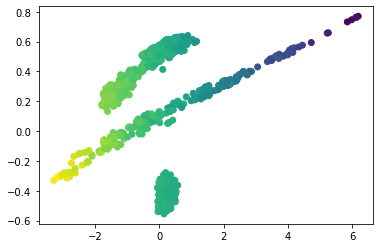

In [25]:
kpcovr_hypers = dict(mixing=0.5, n_components=5)

kpcovr = KPCovR(kernel="linear", center=True, **kpcovr_hypers)
kpcovr.fit(
    Phi_train, Y_train, 
    Yhat=Yp_train # This will throw an error if the RidgeCV in Section 3 has been skipped. 
)  

T_train = kpcovr.transform(Phi_train)
T_test = kpcovr.transform(Phi_test)
plt.scatter(T_train[:, 0], T_train[:, 1], c=Yp_train[:, 0])

In [26]:
# np.savez('kpcovr_file.npz', T_train=T_train, T_test=T_test)

### Skip Computing KPCovR

In [27]:
# # Import kpcovr projection from numpy file

# kpcovr_file = 'kpcovr_file.npz'
# data = np.load(kpcovr_file)
# T_train = data['T_train']
# T_test = data['T_test']

### Compare the predictive power of KPCovR and KPCA components

In [28]:
# r = RidgeCV(cv=4, fit_intercept=False, alphas=np.logspace(-8, 2, 10))
# r.fit(T_train, Y_train)

# Yp_test = r.predict(T_test)
# rmse = calc_rmse(Yp_test, Y_test, y_scaler)

# print(
#     f"The regression on {kpcovr.n_components} KPCovR principal components has an RMSE of {rmse}ppm on the testing set."
# )

# from sklearn.decomposition import KernelPCA

# kpca = KernelPCA(n_components=kpcovr.n_components, kernel="linear")
# kpca.fit(Phi_train)
# T_train_kpca = kpca.transform(Phi_train)
# T_test_kpca = kpca.transform(Phi_test)

# r.fit(T_train_kpca, Y_train)
# Yp_kpca_test = r.predict(T_test_kpca)
# rmse = calc_rmse(Yp_kpca_test, Y_test, y_scaler)

# print(
#     f"By comparison, a regression on {kpcovr.n_components} KPCA components gives an RMSE of {rmse}ppm."
# )

# Exporting to chemiscope

In [29]:
import chemiscope

output_name = "kpcovr-chemiscope.json"

Chemiscope is an online interactive visualizer that allows you to look at the projection in relation with the structures. Here, we'll create a chemiscope input file combining the training set and the testing set.

In [30]:
T = np.zeros((X_raw.shape[0], kpcovr.n_components))
T[i_test] = T_test
T[i_train] = T_train

train_test = np.zeros(X_raw.shape[0])
train_test[i_train] = 1

is_active = np.zeros(X_raw.shape[0])
is_active[i_train[sample_idx]] = 1

n_cur = 10
cur_features = np.zeros((X_raw.shape[0], n_cur))
cur_features[i_test] = X_raw_test[:, cur_idx[:n_cur]]
cur_features[i_train] = X_raw_train[:, cur_idx[:n_cur]]

chemiscope_properties = chemiscope_properties = {
    "kpcovr": {
        "target": "atom", 
        "values": T[:, :kpcovr.n_components]
    },
    "cur_feature": {
        "target": "atom", 
        "values": cur_features[:, :n_cur]
   },
    **{
        prop_name: {"target": target, "values": Y[:, i]}
        for i, prop_name in enumerate(properties)
    },
    "is_training_point": {"target": target, "values": train_test},
    "is_active_point": {"target": target, "values": is_active},
}

meta = {
    "name": "...",  # str, dataset name
    "description": "...",  # str, dataset description
    "authors": [  # list of str, dataset authors, OPTIONAL
        "...",
    ],
    "references": [  # list of str, references for this dataset,
        "...",  # OPTIONAL
    ],
}

In [31]:
chemiscope.write_input(
    output_name,
    frames=frames,
    properties=chemiscope_properties,
    meta=meta,
    cutoff=hypers["interaction_cutoff"],
)